In [0]:
!cp drive/My\ Drive/freelancer-works/my-freelancer-dataset.zip .
!unzip my-freelancer-dataset.zip

Archive:  my-freelancer-dataset.zip
   creating: my-freelancer-dataset/
  inflating: my-freelancer-dataset/train13519.csv  
  inflating: my-freelancer-dataset/train13619.csv  
  inflating: my-freelancer-dataset/train13720.csv  
  inflating: my-freelancer-dataset/train13820.csv  
  inflating: my-freelancer-dataset/train13919.csv  
  inflating: my-freelancer-dataset/train14019.csv  
  inflating: my-freelancer-dataset/train14119.csv  
  inflating: my-freelancer-dataset/train14120.csv  
  inflating: my-freelancer-dataset/train14219.csv  
  inflating: my-freelancer-dataset/train14420.csv  
  inflating: my-freelancer-dataset/train14519.csv  
  inflating: my-freelancer-dataset/train14619.csv  
  inflating: my-freelancer-dataset/train14719.csv  
  inflating: my-freelancer-dataset/train14720.csv  
  inflating: my-freelancer-dataset/train14819.csv  
  inflating: my-freelancer-dataset/train14820.csv  
  inflating: my-freelancer-dataset/train14919.csv  
  inflating: my-freelancer-dataset/train1492

### Merging all CSV files into one

In [0]:
import pandas as pd
import glob

path = 'my-freelancer-dataset'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
print(df.head(3))

             timestamp  hourly_traffic_count
0  2015-10-04 00:00:00                    48
1  2015-10-04 00:05:00                     1
2  2015-10-04 00:10:00                     0


### Descriptive Analysis

In [0]:
df.describe()

,hourly_traffic_count
count,927360.000000
mean,31.130331
std,61.257467
min,0.000000
25%,0.000000
50%,2.000000
75%,36.000000
max,603.000000


### Getting new features

In [0]:
df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
df['weekday'] = df['timestamp'].dt.weekday

# Feature engineering with the date
df['year']= df['timestamp'].dt.year 
df['month']= df['timestamp'].dt.month 
df['day']= df['timestamp'].dt.day

df.head(3)

original_df = df.copy()

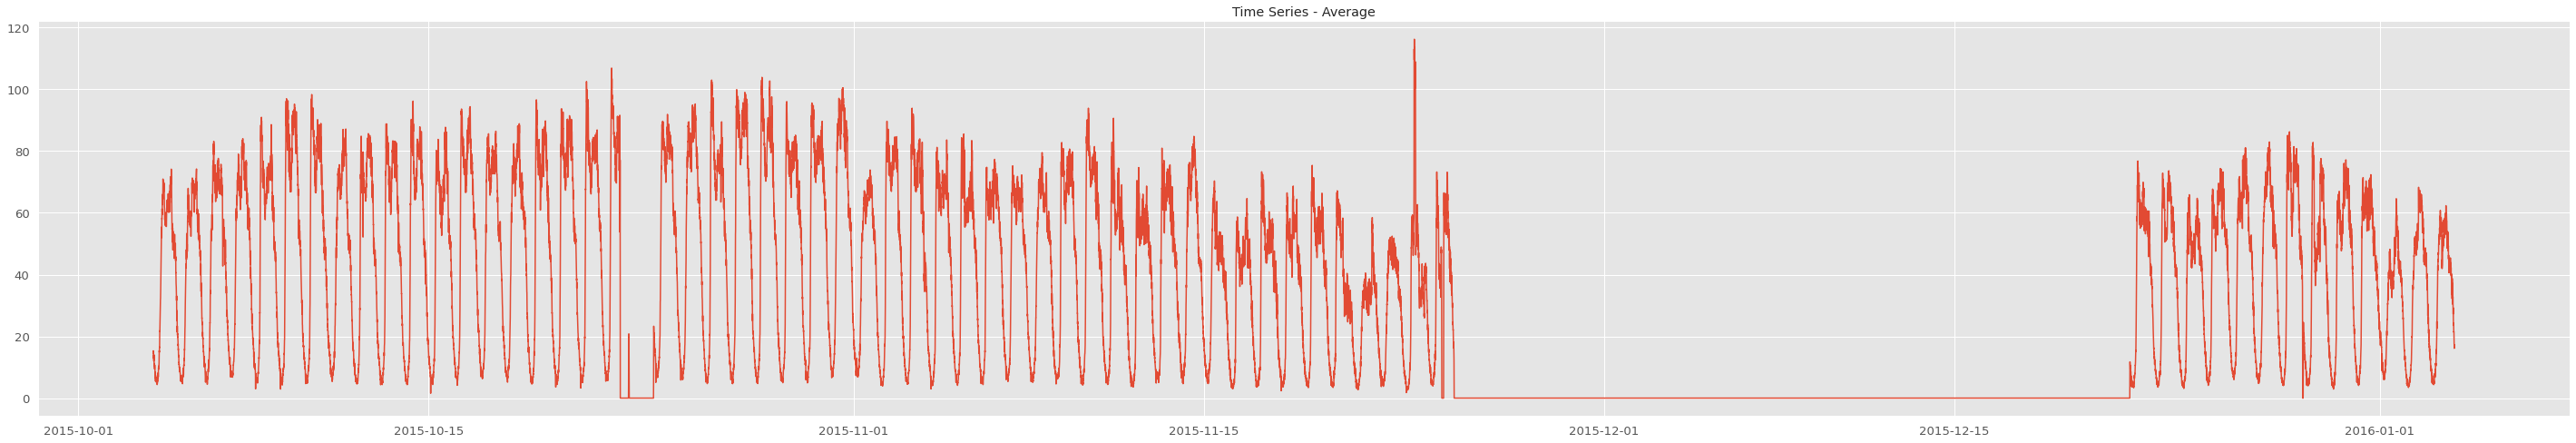

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(50, 8))
mean_group = df[['timestamp','hourly_traffic_count']].groupby(['timestamp'])['hourly_traffic_count'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

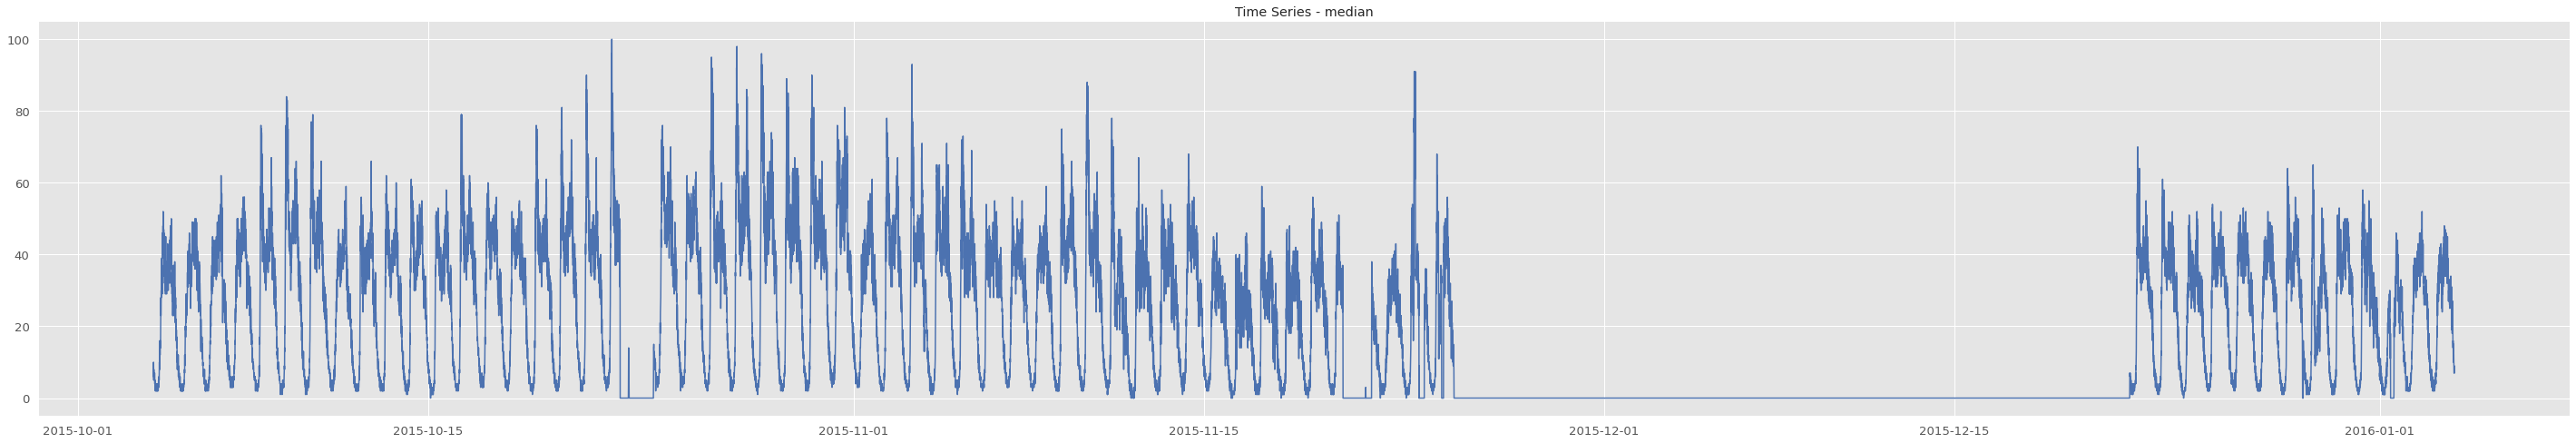

In [0]:
plt.figure(figsize=(50, 8))
median_group = df[['timestamp','hourly_traffic_count']].groupby(['timestamp'])['hourly_traffic_count'].median()
plt.plot(median_group, color = 'b')
plt.title('Time Series - median')
plt.show()

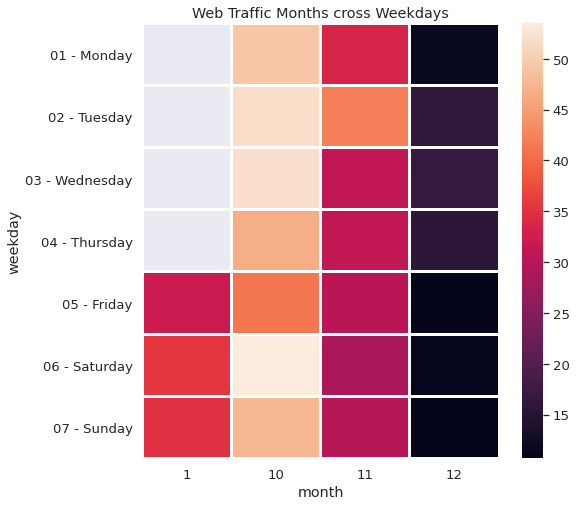

In [0]:
# For the next graphic


df['weekday_num'] = df['weekday']
df['weekday'].replace(0,'01 - Monday',inplace=True)
df['weekday'].replace(1,'02 - Tuesday',inplace=True)
df['weekday'].replace(2,'03 - Wednesday',inplace=True)
df['weekday'].replace(3,'04 - Thursday',inplace=True)
df['weekday'].replace(4,'05 - Friday',inplace=True)
df['weekday'].replace(5,'06 - Saturday',inplace=True)
df['weekday'].replace(6,'07 - Sunday',inplace=True)

train_group = df.groupby(["month", "weekday"])['hourly_traffic_count'].mean().reset_index()
train_group = train_group.pivot('weekday','month','hourly_traffic_count')
train_group.sort_index(inplace=True)

import seaborn as sns
sns.set(font_scale=1.2) 

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross Weekdays')
plt.show()

##### We can clearly see that there is no activity during the December and people during Octobor contributed the highest activity 

In [0]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means['weekday'] = times_series_means['timestamp'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['timestamp'].apply(lambda x: str(x))
times_series_means[['year','month','day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-',2).tolist(), columns = ['year','month','day'])
date_staging = pd.DataFrame(times_series_means['day'].str.split(' ',2).tolist(), columns = ['day','other'])
times_series_means['day'] = date_staging['day']*1
times_series_means.drop('Date_str',axis = 1, inplace =True)
del times_series_means['timestamp']
times_series_means.head()

,hourly_traffic_count,weekday,year,month,day
0,14.514286,6,2015,10,04
1,15.314286,6,2015,10,04
2,15.200000,6,2015,10,04
3,12.885714,6,2015,10,04
4,12.885714,6,2015,10,04


#### Train/Test Preparation

In [0]:
from sklearn.model_selection import train_test_split

X, y = times_series_means.drop(['hourly_traffic_count','year'],axis=1), times_series_means['hourly_traffic_count']
trainx, testx, trainy, testy = train_test_split(X, y, test_size=0.2)


# Linear Model
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def modelisation(x_tr, y_tr, x_ts, y_ts, model):
    # Modelisation with all product
    model.fit(x_tr, y_tr)

    prediction = model.predict(x_ts)
    r2 = r2_score(y_ts.to_numpy(), model.predict(x_ts))
    mae = mean_absolute_error(y_ts.to_numpy(), model.predict(x_ts))
    print ("-----------------------------------------------")
    print ("mae with 80% of the data to train:", mae)
    print ("-----------------------------------------------")
    
    return  prediction, model

model =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

prediction, clr = modelisation(trainx, trainy, testx, testy, model)

-----------------------------------------------
mae with 80% of the data to train: 16.864948731011015
-----------------------------------------------


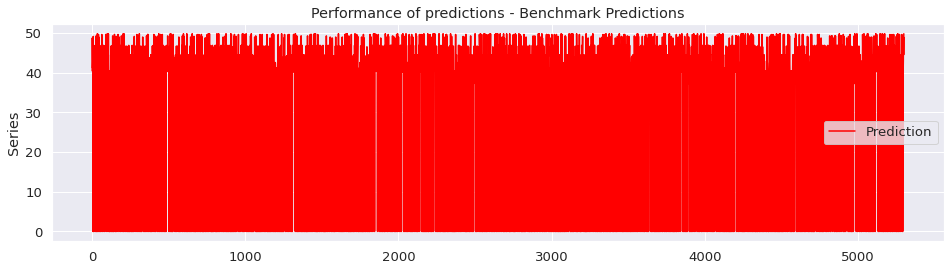

In [0]:
import numpy as np
plt.figure(figsize=(16, 4))
line_up, = plt.plot(prediction,label='Prediction', color="red")
plt.ylabel('Series')
plt.legend(handles=[line_up])
plt.title('Performance of predictions - Benchmark Predictions')
plt.show()

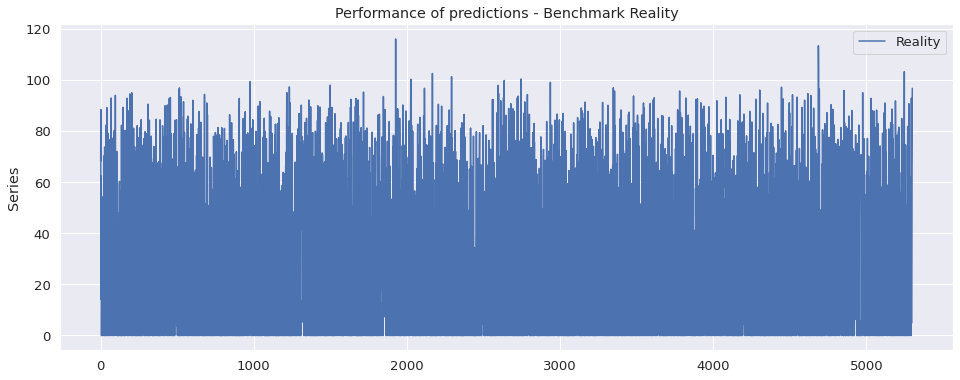

In [0]:
plt.figure(figsize=(16, 6))
line_down, = plt.plot(np.array(testy),label='Reality')
plt.ylabel('Series')
plt.legend(handles=[line_down])
plt.title('Performance of predictions - Benchmark Reality')
plt.show()

In [0]:
trainx.shape

(21196, 4)

### Keras LSTM

In [0]:
trainx.head()

,weekday,year,month,day
16799,1,2015,12,01
6903,1,2015,10,27
3973,5,2015,10,17
14714,1,2015,11,24
24757,0,2015,12,28


In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from pandas import DataFrame, concat
from sklearn.preprocessing import MinMaxScaler


X, y = times_series_means.drop(['hourly_traffic_count','year'],axis=1), times_series_means['hourly_traffic_count']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X)

trainx, testx, trainy, testy = train_test_split(scaled, y, test_size=0.2)


trainx = trainx.reshape((trainx.shape[0], 1, trainx.shape[1]))
testx = testx.reshape((testx.shape[0], 1, testx.shape[1]))
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(trainx.shape[1], trainx.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(trainx, trainy, epochs=50, batch_size=8, validation_data=(testx, testy), verbose=2, shuffle=False)

Train on 21196 samples, validate on 5300 samples
Epoch 1/50
 - 23s - loss: 27.9986 - val_loss: 27.4387
Epoch 2/50
 - 20s - loss: 27.4803 - val_loss: 27.2732
Epoch 3/50
 - 21s - loss: 27.2311 - val_loss: 26.9031
Epoch 4/50
 - 21s - loss: 26.7484 - val_loss: 26.3414
Epoch 5/50
 - 21s - loss: 26.1751 - val_loss: 25.7987
Epoch 6/50
 - 21s - loss: 25.7274 - val_loss: 25.3681
Epoch 7/50
 - 20s - loss: 25.3547 - val_loss: 24.9272
Epoch 8/50
 - 20s - loss: 24.8500 - val_loss: 24.2905
Epoch 9/50
 - 20s - loss: 24.1032 - val_loss: 23.5265
Epoch 10/50
 - 20s - loss: 23.3198 - val_loss: 22.8063
Epoch 11/50
 - 21s - loss: 22.6450 - val_loss: 22.2220
Epoch 12/50
 - 21s - loss: 22.1690 - val_loss: 21.7997
Epoch 13/50
 - 22s - loss: 21.8913 - val_loss: 21.5988
Epoch 14/50
 - 22s - loss: 21.7710 - val_loss: 21.5103
Epoch 15/50
 - 24s - loss: 21.7159 - val_loss: 21.4455
Epoch 16/50
 - 24s - loss: 21.6630 - val_loss: 21.3694
Epoch 17/50
 - 23s - loss: 21.6095 - val_loss: 21.3125
Epoch 18/50
 - 24s - loss

#### Plot history and Evaluation

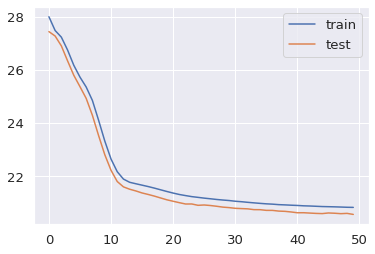

Test RMSE: 27.020


In [0]:
from sklearn.metrics import mean_squared_error

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
 
# make a prediction
yhat = model.predict(testx)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.3f' % rmse)